## Курсовой проект по курсу "Библиотеки Python для анализа данных". Юрий Андреев.

### Импорт модулей и установка глобальных переменных

In [1]:
import re
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, f1_score

from imblearn.over_sampling import SMOTE, ADASYN

!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
TRAIN_DATASET_PATH = '../course_project_train.csv'
TEST_DATASET_PATH = '../course_project_test.csv'

### 1. Обзор датасета

In [3]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

Посмотрим размерность таблиц, и что из себя представляют первые 5 строк.

In [4]:
df_train.shape, df_test.shape

((7500, 17), (2500, 16))

In [5]:
df_train.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0


Определим, какие данные будут недоступны в тестовом датасете

In [6]:
set(df_train.columns) - set(df_test.columns)

{'Credit Default'}

In [7]:
df_train.sample(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4598,Home Mortgage,1313223.0,10+ years,0.0,13.0,20.9,958562.0,0.0,NaN,0.0,debt consolidation,Long Term,99999999.0,319561.0,13461.0,730.0,0
7488,Rent,465405.0,5 years,0.0,5.0,7.7,51744.0,0.0,33.0,0.0,home improvements,Short Term,129338.0,8721.0,13535.0,728.0,0
6293,Rent,613320.0,< 1 year,0.0,8.0,15.3,201058.0,0.0,NaN,0.0,debt consolidation,Long Term,223322.0,61294.0,8137.0,745.0,0
1938,Rent,1423993.0,9 years,0.0,7.0,11.7,492514.0,0.0,NaN,0.0,debt consolidation,Long Term,427812.0,302005.0,8259.0,698.0,0
2054,Rent,NaN,8 years,0.0,5.0,9.7,204182.0,0.0,NaN,0.0,debt consolidation,Short Term,180202.0,104747.0,14280.0,NaN,0


Посмотрим, какие уникальные значения есть в наиболее интересных столбцах

In [8]:
df_train['Home Ownership'].unique()

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

In [9]:
sorted(df_train['Tax Liens'].unique())

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [10]:
sorted(df_train['Months since last delinquent'].unique())[:10]

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [11]:
sorted(df_train['Months since last delinquent'].unique())[-10:]

[79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 86.0, 91.0, 92.0, 118.0]

Months since last delinquent - интересный параметр с большим количеством целочисленных значений. 
Посмотрим, какая у него мода, и построим колоночную диаграмму, чтобы лучше понимать распределение

In [12]:
df_train['Months since last delinquent'].mode()

0    14.0
dtype: float64

In [13]:
msld_dict = {}
for id, frame in df_train.groupby('Months since last delinquent'):
    msld_dict[id] = len(frame)

<BarContainer object of 89 artists>

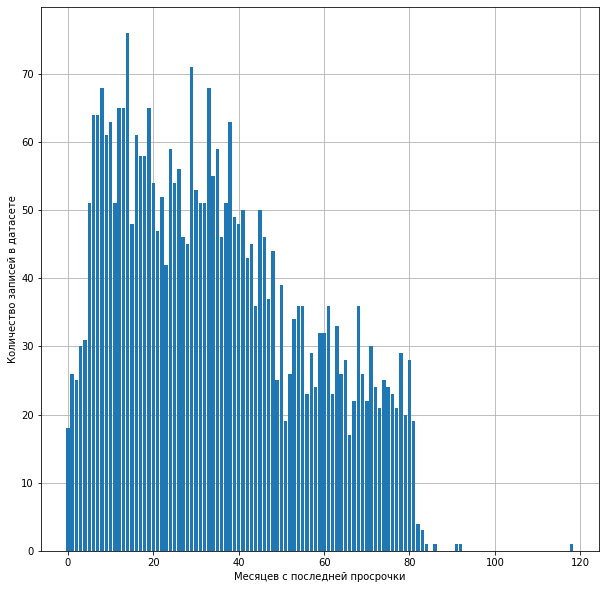

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(zorder=0)
ax.set_ylabel('Количество записей в датасете')
ax.set_xlabel('Месяцев с последней просрочки')
ax.bar(msld_dict.keys(), msld_dict.values(), zorder=3)

In [15]:
sorted(df_train['Bankruptcies'].unique())

[0.0, 1.0, 2.0, 3.0, nan, 4.0]

In [16]:
df_train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

Это категорийное поле не позволяет нам построить таблицу корреляции. Заменим категорийные значения на float с использованием pandas.apply()
Будем применять изменения сразу на тренировочном и на тестовом датасетах, так как они должны быть идентичны по структуре

In [17]:
yicj_voc = {}
for term in df_train['Years in current job'].unique():
    if pd.isnull(term):
        yicj_voc[term] = np.NaN
    elif term == '< 1 year':
        yicj_voc[term] = 0.5
    else:
        yicj_voc[term] = float(re.findall('\d+', term)[0])

def cat_to_float(row, *args):
    return args[0].get(row)

In [18]:
df_train['Years in current job'] = df_train['Years in current job'].apply(cat_to_float, args = (yicj_voc,))
df_test['Years in current job'] = df_test['Years in current job'].apply(cat_to_float, args = (yicj_voc,))

Credit Score - явно какая-то метрика, рассчитываемая на основе остальных данных. Интересно, при каких параметрах можно получить наименьшее и наибольшее значение этого параметра

In [19]:
df_train.sort_values(by=['Credit Score'])[:5]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
599,Own Home,1265020.0,10.0,0.0,18.0,11.4,1124750.0,0.0,NaN,0.0,other,Long Term,448448.0,518719.0,26987.0,585.0,1
6114,Rent,1330798.0,10.0,0.0,8.0,23.1,1065350.0,0.0,NaN,0.0,debt consolidation,Long Term,676346.0,574123.0,13863.0,586.0,1
1455,Home Mortgage,1321697.0,1.0,0.0,11.0,22.7,419826.0,0.0,22.0,0.0,debt consolidation,Long Term,292930.0,287166.0,23570.0,588.0,1
3475,Home Mortgage,1177411.0,10.0,0.0,38.0,10.3,225390.0,0.0,NaN,0.0,small business,Short Term,134376.0,113278.0,3984.0,589.0,1
3491,Home Mortgage,2764918.0,4.0,0.0,8.0,17.5,293568.0,0.0,40.0,0.0,debt consolidation,Long Term,551980.0,247703.0,19124.0,590.0,0


In [20]:
# Если не делать проверку isnull, при сортировке в конце оказываются записи с NaN
df_train[~pd.isnull(df_train['Credit Score'])].sort_values(by=['Credit Score'])[-5:]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1363,Rent,719511.0,10.0,0.0,10.0,24.3,732512.0,0.0,NaN,0.0,debt consolidation,Short Term,111056.0,342266.0,6500.0,7490.0,1
355,Rent,960184.0,10.0,0.0,9.0,43.3,301026.0,0.0,42.0,0.0,debt consolidation,Short Term,87912.0,86051.0,3433.0,7500.0,1
2408,Home Mortgage,973085.0,8.0,0.0,16.0,16.0,1937320.0,0.0,NaN,0.0,debt consolidation,Short Term,332156.0,493582.0,17029.0,7500.0,1
3688,Home Mortgage,2290944.0,1.0,0.0,16.0,18.0,2225168.0,0.0,19.0,0.0,other,Short Term,371382.0,322848.0,4257.0,7510.0,1
2213,Own Home,542735.0,10.0,0.0,9.0,16.0,357874.0,0.0,NaN,0.0,other,Short Term,321266.0,101384.0,7824.0,7510.0,1


Построим таблицу корреляций параметров

<AxesSubplot:>

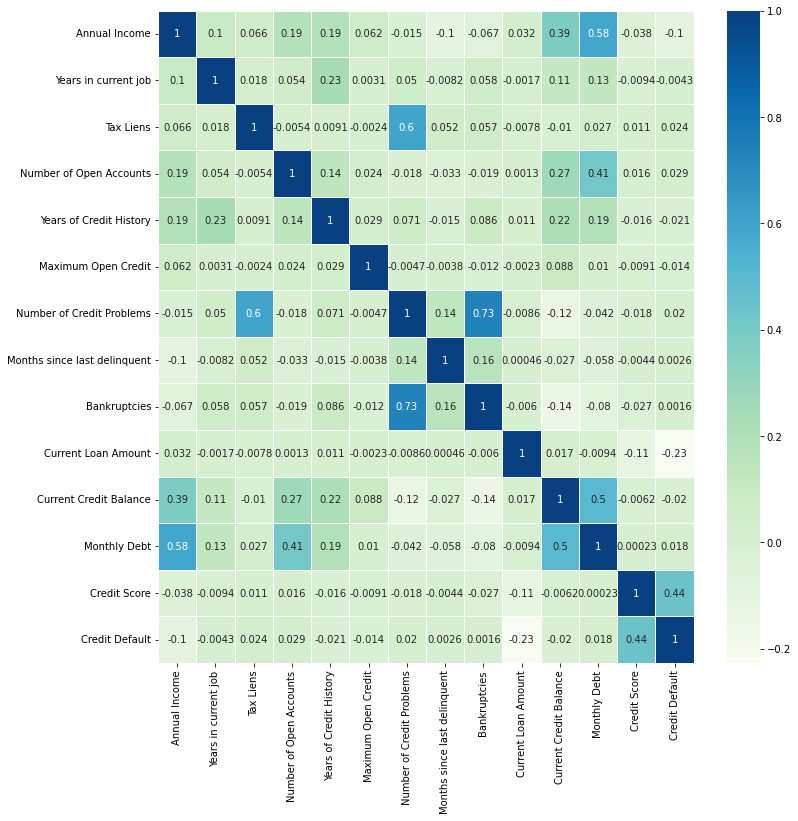

In [21]:
df_corr = df_train.corr(min_periods=100)

fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df_corr, annot = True, linewidths=.5, ax = ax, cmap='GnBu')

Наивысшая корреляция - 0.73 - между количеством кредитных проблем и количеством банкротств, что следовало ожидать. Следующая по убыванию - 0.6 - связь количества кредитных проблем с налоговыми обременениями - также достаточно предсказуемо. Третья - 0.58 - связь ежемесячного долга с доходом. Также понятная закономерность - больше человек зарабатывает, тем больше может взять в долг. Интересовавший нас параметр Credit Score не коррелирует ни с какими столбцами, кроме Credit Default на уровне 0.44. Т.е., не очень понятный параметр, непрозрачна методика его расчета для каждого пользователя.

### 2. Обработка пропусков 3. Обработка выбросов

Желтым выделены поля, имеющие пропуски:

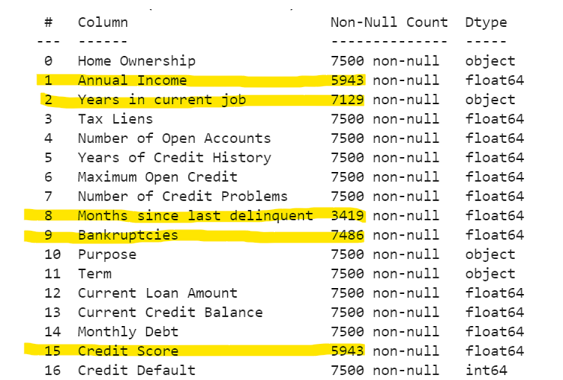

1. Банкротства. Отсутствует всего 14 значений из 7500 тысяч. Ввиду самой высокой во всем датасете корреляции с параметром Number of Credit Problems превратим дискретные значения целого количества банкротств в непрерывные и заполним отсутствующие значения по пропорции, взятой из Number of Credit Problems
2. Years in current job - превратим категорийные значения в непрерывные и заполним отсутствующие медианой, так как этот параметр имеет низкую корреляцию с любыми другими
3. Годовой доход - заполняем медианой.
4. Количество месяцев после последнего нарушения. Целесообразно заполнять модой, равной 14 месяцам. Важным было бы значение этого параметра, равное нулю (отсутствие нарушений), однако таких записей всего 18 на весь датасет, поэтому заполнять отсутствующие значения нулями видится не совсем корректным.
5. Крединтный рейтинг - непрозрачный некоррелирующий с другими параметрами столбец. Имеет смысл заполнять медианой. 

Перед заполнением средними необходимо проверить параметры на наличие выбросов и исключить их из расчета

Проверяем выбросы с помощью box-plot и z-метрики. Параметр whis задаем в пределах три сигма.
Считаем медианы интересующих нас параметров только в пределах трех сигма

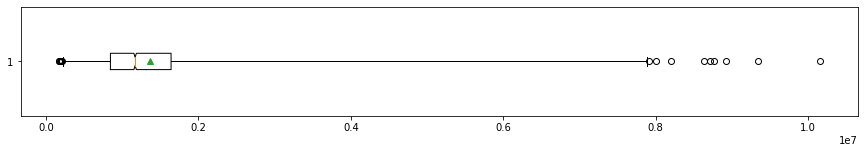

In [22]:
fig, ax = plt.subplots(figsize=(15,2)) 
#Строим boxplot только для значений, не содержащих NaN. 
bp = ax.boxplot(df_train[~pd.isna(df_train['Annual Income'])]['Annual Income'], 
                showmeans = True, notch = True, vert = False, whis = (0.135, 99.865))

In [23]:
z = np.abs(stats.zscore(df_train[~pd.isna(df_train['Annual Income'])]['Annual Income']))
ai_median = df_train['Annual Income'].iloc[np.where(z < 3)].median() #медиана для годового дохода, рассчитанная без выбросов

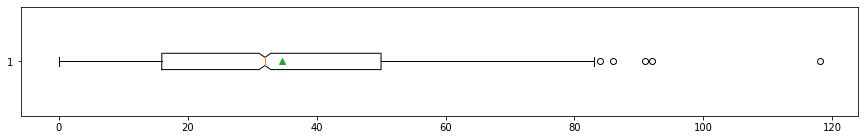

In [24]:
fig, ax = plt.subplots(figsize=(15,2)) 
#Строим boxplot только для значений, не содержащих NaN. 
bp = ax.boxplot(df_train[~pd.isna(df_train['Months since last delinquent'])]['Months since last delinquent'], 
                showmeans = True, notch = True, vert = False, whis = (0.135, 99.865))

In [25]:
z = np.abs(stats.zscore(df_train[~pd.isna(df_train['Months since last delinquent'])]['Months since last delinquent']))
msld_median = df_train['Months since last delinquent'].iloc[np.where(z < 3)].median() #медиана для количества месяцев с последней просрочки,
                                                                                      #рассчитанная без выбросов

Заполняем отсутствующие значения в тренировочном и тестовом датасетах

In [26]:
df_train.loc[:,'Annual Income'].fillna(value = ai_median, inplace = True)
df_test.loc[:,'Annual Income'].fillna(value = ai_median, inplace = True)

In [27]:
yicj_median = df_train['Years in current job'].median()
df_train.loc[:,'Years in current job'].fillna(value = yicj_median, inplace = True)
df_test.loc[:,'Years in current job'].fillna(value = yicj_median, inplace = True)

In [28]:
cscore_median = df_train['Credit Score'].median()
df_train.loc[:,'Credit Score'].fillna(value = cscore_median, inplace = True)
df_test.loc[:,'Credit Score'].fillna(value = cscore_median, inplace = True)

In [29]:
df_train.loc[:,'Months since last delinquent'].fillna(value = msld_median, inplace = True)
df_test.loc[:,'Months since last delinquent'].fillna(value = msld_median, inplace = True)

In [30]:
credit_problems_range = df_train['Number of Credit Problems'].max() - df_train['Number of Credit Problems'].min()
bnk_range = df_train['Bankruptcies'].max() - df_train['Bankruptcies'].min()

def bnk_fillna(row):
    if pd.isna(row['Bankruptcies']):
        proportion = row['Number of Credit Problems']/credit_problems_range
        row['Bankruptcies'] = proportion*bnk_range
#         print("row['Number of Credit Problems'] = ", row['Number of Credit Problems'])
#         print("filling na value with", proportion*bnk_range)
    return row

df_train = df_train.apply(bnk_fillna, axis = 1)
df_test = df_test.apply(bnk_fillna, axis = 1)

### 4. Анализ данных  5. Отбор признаков  6. Балансировка классов 7. Получение baseline

Проверим, как представлены классы в тренировочном датасете

In [31]:
len(df_train[df_train['Credit Default'] == 0])

5387

In [32]:
len(df_train[df_train['Credit Default'] == 1])

2113

Датасет несбалансирован. Необходимо выполнить балансировку классов, после чего разделить тренировочный датасет на тренировочный и валидационный датасеты. Но сначала попробуем получить baseline на несбалансированном датасете, чтобы понимать, получаем ли мы какое-то улучшение от предпринимаемых попыток оптимизации датасета.

В качестве baseline будем использовать классификатор Random Forest из пакета Scikit Learn. Так как он не может работать с категорийными переменными, необходимо конвертировать параметры Home Ownership, Purpose и Term в численные

Необходимо выполнять кодирование категорийных параметров идентично в тестовом и тренировочном датасетах. Для этого потребуется выполнить конкатенацию датасетов для получения кодов

In [33]:
df_combined = df_train.iloc[:,:-1].append(df_test)

In [34]:
df_combined.shape, df_train.shape, df_test.shape

((10000, 16), (7500, 17), (2500, 16))

In [35]:
#df_train = pd.get_dummies(df_train, columns = ['Home Ownership', 'Purpose', 'Term'])

oe = OrdinalEncoder()
encoded = oe.fit_transform(df_combined[['Home Ownership', 'Purpose', 'Term']])

df_train['Home Ownership'] = encoded[:7500, 0]
df_train['Purpose'] = encoded[:7500, 1]
df_train['Term'] = encoded[:7500, 2]
df_test['Home Ownership'] = encoded[7500:, 0]
df_test['Purpose'] = encoded[7500:, 1]
df_test['Term'] = encoded[7500:, 2]

Построим матрицу корреляции еще раз, чтобы на нее попали категорийные параметры, не отображавшиеся ранее. Заметной корреляции целевого параметрв с другими параметрами, кроме кредитного рейтинга, по-прежнему не наблюдается

<AxesSubplot:>

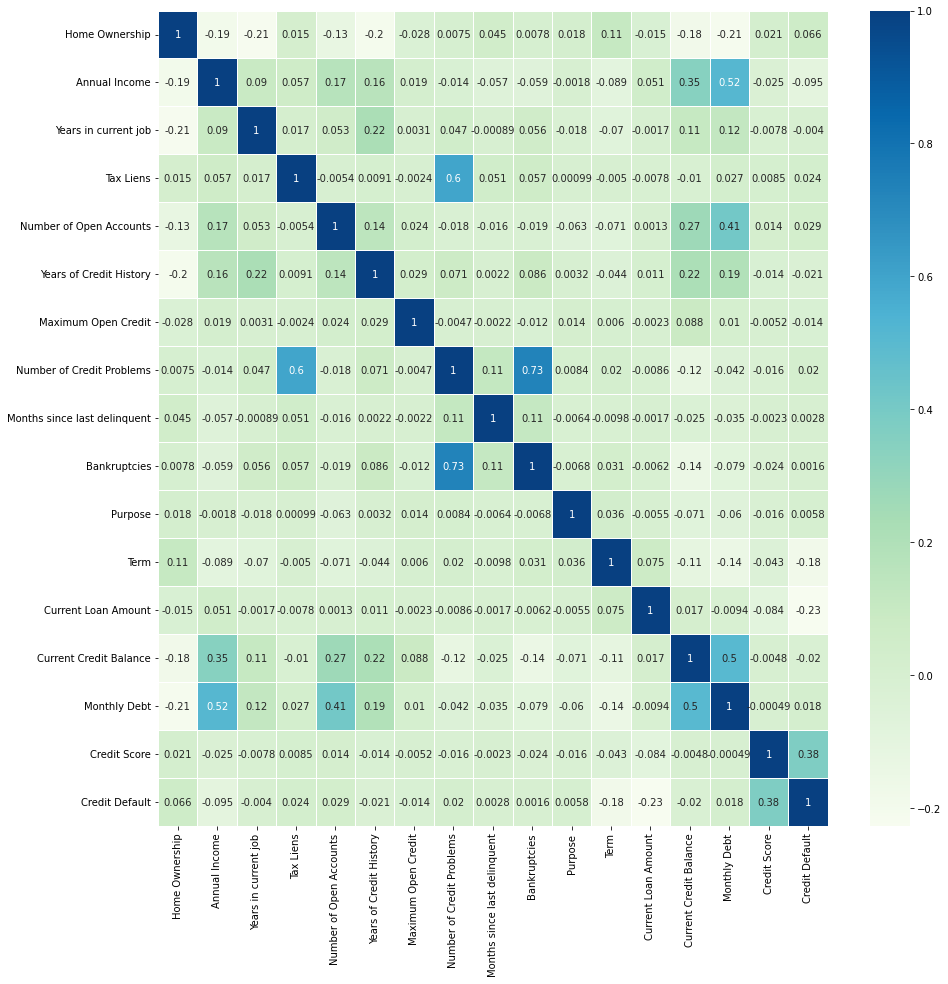

In [36]:
df_corr = df_train.corr(min_periods=100)

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(df_corr, annot = True, linewidths=.5, ax = ax, cmap='GnBu')

Разобьем тренировочный датасет на тренировочный и валидационный наборы, чтобы проверять работу классификатора

In [37]:
df_train_x, df_val_x, df_train_y, df_val_y = train_test_split(df_train.loc[:, df_train.columns != 'Credit Default'], 
                                                              df_train.loc[:, 'Credit Default'], test_size=0.1)

Получим baseline на основе Random Forest, отрисуем матрицу оишибок, PR Curve и ROC Curve

In [38]:
model = RandomForestClassifier(n_estimators=500, bootstrap = True, max_features = 'sqrt')
model.fit(df_train_x, df_train_y)
y_pred = model.predict(df_val_x)

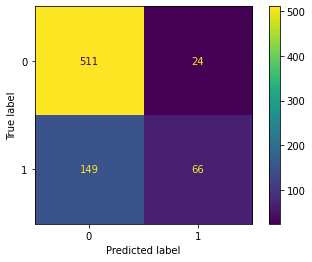

In [39]:
ConfusionMatrixDisplay.from_predictions(df_val_y, y_pred)

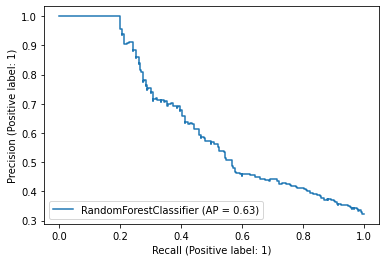

In [40]:
PrecisionRecallDisplay.from_estimator(model, df_val_x, df_val_y)

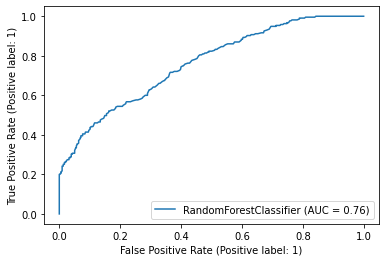

In [41]:
RocCurveDisplay.from_estimator(model, df_val_x, df_val_y)

In [42]:
f1_score(df_val_y, y_pred)

0.43278688524590164

Baseline на случайно полученном валидационном наборе дает неудовлетворительный результат, так как целевое значение f1score должно быть не менее 0.5. Однако, так как в тренировочном датасете меньше данных из-за выделения валидационного, корректнее будет проверить результативность модели на CV - выполнено ниже. 

Анализ графиков и матрицы ошибок показывает, что низкое значение f1score обусловлено низкой чувствительностью модели.

Выполним балансировку классов методом SMOTE

In [43]:
df_train_x_smote, df_train_y_smote = SMOTE().fit_resample(df_train_x, df_train_y)

In [44]:
len(df_train_x_smote), len(df_train_y_smote)

(9704, 9704)

In [45]:
model = RandomForestClassifier(n_estimators=500, bootstrap = True, max_features = 'sqrt')
model.fit(df_train_x_smote, df_train_y_smote)
y_pred_smote = model.predict(df_val_x)

In [46]:
f1_score(df_val_y, y_pred_smote)

0.47928994082840237

Cмогли улучшить f1score, но значение все еще неудовлетворительное. При этом при каждом прогоне из-за стохастического характера работы сэмплера и разбиения train/val каждый раз получаем существенно отличающиеся результаты от 0.42 до 0.49, поэтому необходимо использовать n-fold cv



Применим Cross-Validation, предварительно выполнив SMOTE-балансировку датасетов



In [47]:
df_train_x_smote_cv, df_train_y_smote_cv = SMOTE().fit_resample(df_train.loc[:, df_train.columns != 'Credit Default'], df_train.loc[:, 'Credit Default'])
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, df_train_x_smote, df_train_y_smote, cv=5, scoring='f1')
scores.mean()

0.785452045432168

Получен baseline на основе классификатора Random Forest с дефолтными гиперпараметрами

### 8. Выбор наилучшей модели, настройка гиперпараметров 9. Проверка качества, борьба с переобучением 10. Интерпретация результатов

Попробуем улучшить результат baseline, вопсопльзовавшись классификатором CatBoost

In [48]:
from catboost import CatBoostClassifier, Pool, cv
from catboost import metrics as cb_metrics

Catboost на странице своей документации предлагает использовать не sklearn gridsearch, а утилиту hyperopt. Используя sklearn grid search не удается провести поиск, так как конструктор модели выдает ошибку. Вероятно, они несовместимы. Поиск довольно долгий, в целях ускорения ячейки закомментированы, и ниже оптимальный результат сразу сохранен в словарь best.
Поиск выполняется по параметрам коэффициента при множителе регуляризации L2, а также по параметру learning rate


Для борьбы с переобучением помимо L2-регуляризации в catboost используются два включенных по умолчанию параметра - это use_best_model и early_stop. В процессе обучения библиотека контролирует результирующую функцию потерь и выполняет остановку бустинга на итерации, дающей лучший резульат (точка минимума по оси X для функции потерь от количества итераций - см. ниже графики)

In [49]:
# import hyperopt

# def hyperopt_objective(params):
#     model = CatBoostClassifier(
#         l2_leaf_reg=int(params['l2_leaf_reg']),
#         learning_rate=params['learning_rate'],
#         iterations=500,
#         eval_metric=cb_metrics.F1(),
#         verbose=False,
#         loss_function=cb_metrics.Logloss(),
#     )
    
#     cv_data = cv(
#         Pool(df_train_x_smote, df_train_y_smote),
#         model.get_params()
#     )
#     best_accuracy = np.max(cv_data['test-F1-mean'])
    
#     return 1 - best_accuracy # as hyperopt minimises

In [50]:
# params_space = {
#     'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
#     'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
# }

# trials = hyperopt.Trials()

# best = hyperopt.fmin(
#     hyperopt_objective,
#     space=params_space,
#     algo=hyperopt.tpe.suggest,
#     max_evals=50,
#     trials=trials,
# )

# print(best)

{'l2_leaf_reg': 3.0, 'learning_rate': 0.09689304525025999}

In [51]:
best = {'l2_leaf_reg': 3.0, 'learning_rate': 0.09689304525025999}

Построим модель с параметрами, полученными на выходе GridSearch

In [52]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    custom_loss=[cb_metrics.F1()],
    logging_level='Silent'
)

Выполним обучение модели, построим функцию потерь в зависимости от количества шагов обучения

In [53]:
model.fit(
    df_train_x_smote, df_train_y_smote,
    eval_set=(df_val_x, df_val_y),
    plot=True
);

y_pred = model.predict(df_val_x)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Построим матрицу ошибок, PR Curve и ROC Curve

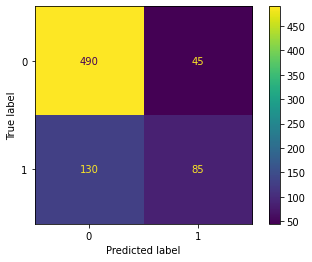

In [54]:
ConfusionMatrixDisplay.from_predictions(df_val_y, y_pred)

In [55]:
f1_score(df_val_y, y_pred)

0.49275362318840576

По матрице ошибок видно, что модель имеет низкую чувствительность по классу 1, так как идентифицирована только треть от всех экземпляров класса 1. При этом количество ложноположительных срабатываний существенно ниже в соотношении с ложноотрицательными. То есть, при текущих параметрах модель "рассматривает" ошибку второго рода как менее критичную, чем ошибку первого рода. Соответственно, наибольший отрицательный вклад в метрику F1 дает низкий recall модели по классу 1.

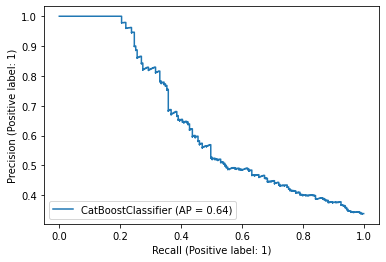

In [56]:
PrecisionRecallDisplay.from_estimator(model, df_val_x, df_val_y)

По графику PR Curve видно резкое снижение точности модели при минимальном увеличении recall. 

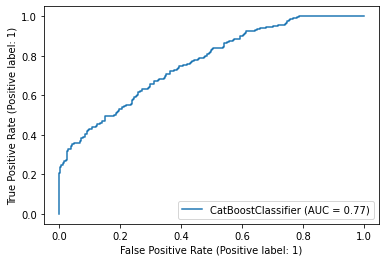

In [57]:
RocCurveDisplay.from_estimator(model, df_val_x, df_val_y)

Значения AUC на валидационном датасете близки к бейслайну, однако CV показывает преимущество catboost по сравнению с дефолтным Random Forest

Выполним расчет целевого параметра на CV. В документации Catboost также предлагается использовать cv из пакета catboost, а не из пакета sklearn. 

In [58]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': cb_metrics.Logloss(),
})
cv_data = cv(
    Pool(df_train_x_smote_cv, df_train_y_smote_cv),
    cv_params,
    fold_count = 5,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Значения на кросс-валидации существенно выше бейслайна:

In [59]:
print('Наилучшая метрика F1 score на валидационном сете: {:.2f}±{:.2f} получена на шаге {}'.format(
    np.max(cv_data['test-F1-mean']),
    cv_data['test-F1-std'][np.argmax(cv_data['test-F1-mean'])],
    np.argmax(cv_data['test-F1-mean'])
))

Наилучшая метрика F1 score на валидационном сете: 0.83±0.00 получена на шаге 444


Построим график важности параметров

In [60]:
feature_importances = model.get_feature_importance()
feature_names = df_train_x_smote.columns
feature_dict = {}
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    feature_dict[name] = score
#     print('{}: {}'.format(name, score))

x = list(feature_dict.values())
y = list(feature_dict.keys())

x.reverse()
y.reverse()

<BarContainer object of 16 artists>

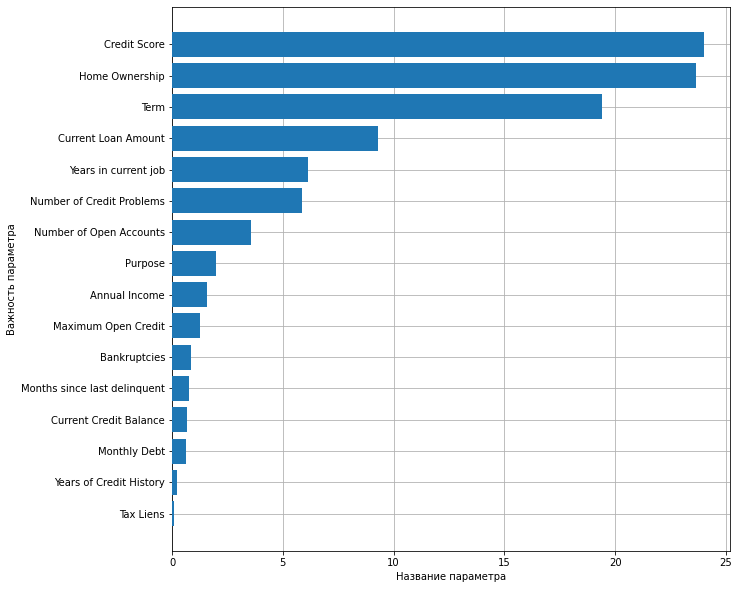

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(zorder=0)
ax.set_ylabel('Важность параметра')
ax.set_xlabel('Название параметра')
ax.barh(y, x, zorder=3)

Любопытно, что непрозрачный параметр Credit Score, который показывал корреляцию с целевым значением, действительно, оказался в списке важнейших. Также интересно, что наиболее важным параметром среди остальных оказались данные о наличии недвижимости в собственности, хотя корреляция этого параметра с целевым близка к нулю

### 11. Получение предсказаний на тестовом датасете

In [62]:
y_pred_test = model.predict(df_test)

In [63]:
pd.DataFrame(y_pred_test).to_csv('YuriyAndreev_predictions.csv', index=False)